In [70]:
import pandas as pd
from datetime import datetime

# Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
from sklearn.base import BaseEstimator, TransformerMixin # to create classes

# Category encoders
from category_encoders import OneHotEncoder, TargetEncoder

from sklearn.utils import resample

In [62]:
!ls -lh data

total 62M
-rw-r--r-- 1 ZukiPC 197609 2,3M ago 12 14:41 sample_submission.csv
-rw-r--r-- 1 ZukiPC 197609 7,8M ago 12 14:41 test.csv
-rw-r--r-- 1 ZukiPC 197609  52M ago 12 14:41 train.csv


In [63]:
data = pd.read_csv('data/train.csv').set_index("id")
data.head()

,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,isfraud
id,,,,,,,,,,,,,,,
202,1413851368636,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
9909,1413851725946,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
22692,1413851873924,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
22938,1413851651534,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
29187,1413853025188,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0


In [64]:
data.shape

(522412, 15)

In [65]:
# Check test set variables
!head data/test.csv

id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount
36412270,1414635923767,c4e18dd6,85f751fd,50e219e0,7358e05e,0007ae57,320,50,2647,2,35,100148,23,191.77
36444068,1414636094030,c4e18dd6,85f751fd,50e219e0,7358e05e,0007ae57,320,50,2647,2,35,100148,23,191.77
37853449,1414662647887,c4e18dd6,85f751fd,50e219e0,7358e05e,0007ae57,320,50,2647,2,39,100148,23,191.77
36396815,1414637084496,c4e18dd6,85f751fd,50e219e0,7358e05e,0007ae57,320,50,2647,2,35,100148,23,191.77
36432507,1414634763247,c4e18dd6,85f751fd,50e219e0,7358e05e,0007ae57,320,50,2647,2,35,100148,105,191.77
38314434,1414670233561,c4e18dd6,85f751fd,50e219e0,7358e05e,0008dcd1,320,50,2741,0,163,-1,17,191.77
38317400,1414669531131,c4e18dd6,85f751fd,50e219e0,7358e05e,0008dcd1,320,50,2741,0,163,-1,105,191.77
36932920,1414642524061,c4e18dd6,85f751fd,50e219e0,5adb10d9,0011cd85,320,50,2726,3,803,100200,229,191.77
36678951,1414644584615,c4e18dd6,85f751fd,50e219e0,5adb10d9,0011cd85,320,50,

EDA

In [66]:
data['timestamp'] = pd.to_datetime(data.timestamp, infer_datetime_format=True)
data.head()

,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,isfraud
id,,,,,,,,,,,,,,,
202,1970-01-01 00:23:33.851368636,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
9909,1970-01-01 00:23:33.851725946,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
22692,1970-01-01 00:23:33.851873924,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
22938,1970-01-01 00:23:33.851651534,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0
29187,1970-01-01 00:23:33.853025188,fa41b2d8,ef5ed6b8,50e219e0,ecad2386,bd544220,300,50,2312,0,167,100075,16,195.65,0


In [7]:
analysis_dict = {'variables': list(data.columns.values),
                 'count': list(data.count().values),
                 'v_types': list(data.dtypes.values),
                 'n_null': list(data.isnull().sum().values),
                 'n_uniques': list(data.nunique().values)}
analysis = pd.DataFrame(analysis_dict)
analysis

,variables,count,v_types,n_null,n_uniques
0,timestamp,522412,int64,0,521650
1,product_id,522412,object,0,1959
2,product_department,522412,object,0,1251
3,product_category,522412,object,0,4
4,card_id,522412,object,0,1668
5,user_id,522412,object,0,82591
6,C15,522412,int64,0,8
7,C16,522412,int64,0,9
8,C17,522412,int64,0,293
9,C18,522412,int64,0,4


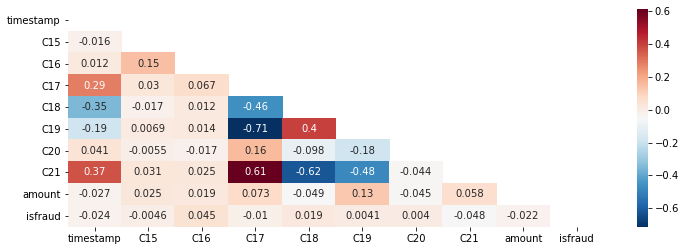

In [8]:
corr_matrix = data.corr()
lower_triangle_mask = np.triu(np.ones(corr_matrix.shape)).astype(np.bool)
cor_mat_lower = corr_matrix.mask(lower_triangle_mask)

plt.figure(figsize = (12,4))

sns.heatmap(cor_mat_lower,
            annot=True,
            cmap='RdBu_r')

plt.show()

In [9]:
cols_to_drop = ['C19', 'C21']

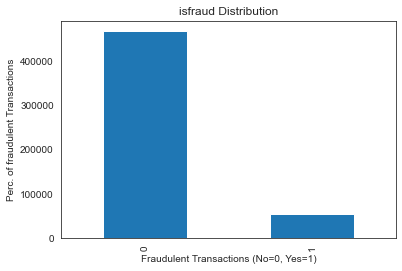

In [25]:
# Checking if the dataset is imbalanced 
sns.set_style("white")
data["isfraud"].value_counts(normalize=False).plot(kind="bar")
plt.title('isfraud Distribution')
plt.xlabel("Fraudulent Transactions (No=0, Yes=1)")
plt.ylabel("Perc. of fraudulent Transactions");

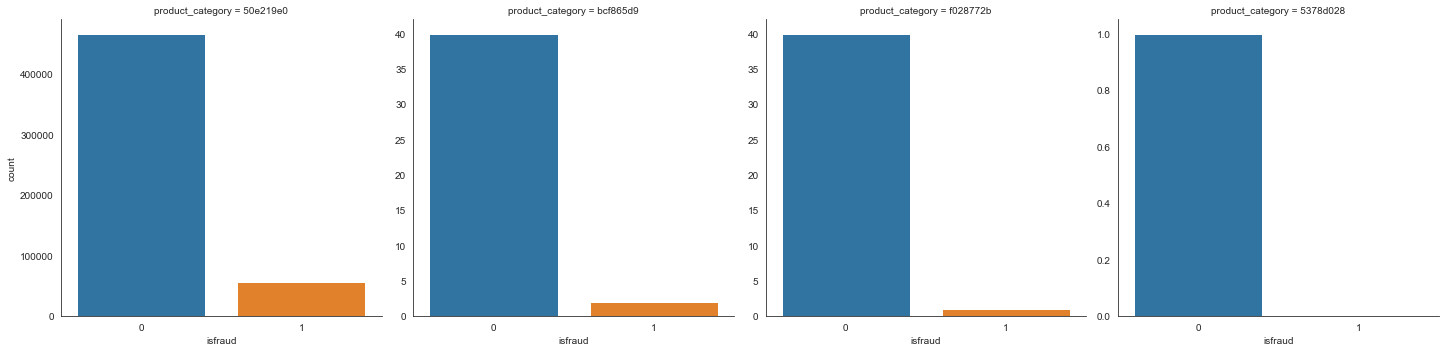

In [26]:
# Checking if the dataset is imbalanced per product_category
g = sns.catplot(data=data[['product_category', 'isfraud']], x='isfraud', col="product_category", col_wrap=4, 
                kind="count", sharex=False, sharey=False)

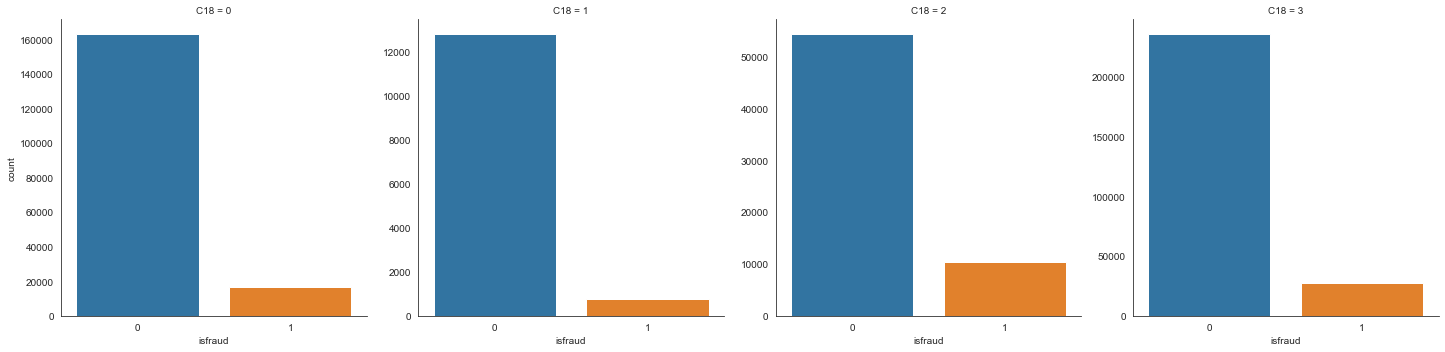

In [27]:
# Checking if the dataset is imbalanced per C18
g = sns.catplot(data=data[['C18', 'isfraud']], x='isfraud', col="C18", col_wrap=4, 
                kind="count", sharex=False, sharey=False)

In [28]:
class DroppingColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X = X.drop(self.cols,axis=1)
        return X

Feature Engineering

In [29]:
class CreateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, col='timestamp'):
        self.col = col
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X["YEAR"] = pd.to_datetime(X[self.col],unit='ms').dt.year
        X["MONTH"] = pd.to_datetime(X[self.col],unit='ms').dt.month
        X["WEEK"] = pd.to_datetime(X[self.col],unit='ms').dt.weekofyear
        X["WEEK_DAY"] = pd.to_datetime(X[self.col],unit='ms').dt.dayofweek
        
        return X

In [53]:
class CreateNewFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X['NB_CARDS'] = X['user_id'].map(X.groupby(['user_id'])['card_id'].nunique().to_dict())
        X['NB_USERS_PER_CARD'] = X['card_id'].map(X.groupby(['card_id'])['user_id'].nunique().to_dict())
        #X["AVG_NB_TRAN_DAY"] = X['user_id'].map(X.groupby(['user_id', 'WEEK_DAY'])['timestamp'].count().groupby(['user_id']).mean().to_dict())
        #X["AVG_NB_TRAN_WEEK"] = X['user_id'].map(X.groupby(['user_id', 'WEEK'])['timestamp'].count().groupby(['user_id']).mean().to_dict())
        #X["AVG_NB_TRAN_MONTH"] = X['user_id'].map(X.groupby(['user_id', 'MONTH'])['timestamp'].count().groupby(['user_id']).mean().to_dict())                                              
        X["AVG_VALUE_PER_TRANS"] = X['user_id'].map(X.groupby(['user_id'])['amount'].mean().to_dict())
        return X

Creating a Model

In [76]:
data = pd.read_csv('data/train.csv').set_index("id")
data = data.sort_values(by="timestamp")
X = data.drop(columns=['isfraud'])
y = data['isfraud']

In [93]:
df_notfraud = data[data.isfraud==0] # (467184, 15)
df_fraud = data[data.isfraud==1] # (55228, 15)

df_notfraud_downsampled = resample(df_notfraud,
                                  replace=False,
                                  n_samples = 261206,
                                  random_state = 42)

df_fraud_upsampled = resample(df_fraud, replace=True, n_samples = 261206, random_state = 42)

df_resampled = pd.concat([df_notfraud_downsampled, df_fraud_upsampled])

X = df_resampled.drop(columns=['isfraud'])
y = df_resampled['isfraud']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [95]:
cols_to_drop = ['C19', 'C21']
#new_time_variables = ['YEAR', 'MONTH', 'WEEK', 'WEEK_DAY']
pipeline = Pipeline([#("create_time_features", CreateTimeFeatures()),
                     ('create_new_features', CreateNewFeatures()),
                     #('onehot_encoding', OneHotEncoder(cols=new_time_variables)),
                     ('Cs_encoding', OneHotEncoder(cols=['C15', 'C16', 'C17', 'C18', 'C20'])),
                     ('target_encoding', TargetEncoder(cols=['product_id', 'product_department', 'product_category', 'card_id', 'user_id'], min_samples_leaf=30)),
                     ('drop_columns', DroppingColumns(cols=cols_to_drop)),
                     ('model', RandomForestClassifier(random_state=42))])

In [96]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('create_new_features', CreateNewFeatures()),
                ('Cs_encoding',
                 OneHotEncoder(cols=['C15', 'C16', 'C17', 'C18', 'C20'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('target_encoding',
                 TargetEncoder(cols=['product_id', 'product_department',
                                     'product_category', 'card_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurit

In [97]:
y_scores = pipeline.predict_proba(X_test)[:,1]

Score: 0.871


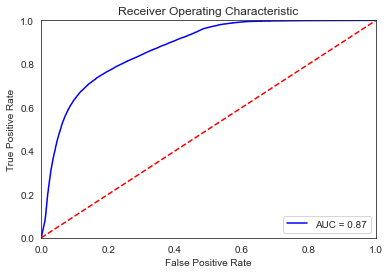

In [98]:
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()